In [1]:
from keras.models import Sequential, load_model
import keras.backend as K
from tensorflow.keras.optimizers import Adam
from keras.layers import SeparableConv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.xception import preprocess_input, Xception
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import numpy as np
import os

from sklearn.metrics import classification_report, confusion_matrix

## Declare some variables & functions

In [3]:
wd = os.path.sep.join([os.getcwd(), "data"])
train_path = os.path.sep.join([wd, "train"])
test_path = os.path.sep.join([wd, "test"])
symblink_path = os.path.sep.join([wd, "symblink"])

In [2]:
def show_results(_model, _hist, metric):
    """
    Used to shows classification report, confusion matrix for the prediction of the test set and learning curves from the training
    :param _model: fitted model
    :param _hist: model's history
    :param metric: metric to show in the learning curves (accuracy/recall)
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.lineplot(x=range(len(_hist[metric])), y=_hist[metric], label=metric, ax=ax)
    sns.lineplot(x=range(len(_hist[metric])), y=_hist["val_"+metric], label="val "+metric, ax=ax)
    sns.lineplot(x=range(len(_hist[metric])), y=_hist["loss"], label="loss", ax=ax)
    sns.lineplot(x=range(len(_hist[metric])), y=_hist["val_loss"], label="val loss", ax=ax)

    y_true = test_gen.classes
    y_pred = np.argmax(model.predict(test_gen), axis=1)

    report = classification_report(y_true, y_pred)
    print(report)

    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues', ax=ax)

def recall(y_true, y_pred):
    """
    Compute the recall metric
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def save(name):
    with open(f"data/{name}.pickle", "wb") as handle:
        pickle.dump(hist, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load(name):
    with open(f"data/{name}.pickle", "rb") as handle:
        return pickle.load(handle)

## Declaration of the image generators used to train models without having to load images in cache
input from multiple directories with keras https://stackoverflow.com/questions/60787620/combine-two-data-generator-to-train-a-cnn

In [4]:
# generators
train_aug = ImageDataGenerator(validation_split=.15, rescale=1 / 255.0)
test_aug = ImageDataGenerator(rescale=1 / 255.0)

# set the flow of generators for the train/test/validation
training_gen_original = train_aug.flow_from_directory(train_path, target_size=(51,51), subset="training", batch_size=32, shuffle=True)
validation_gen_original = train_aug.flow_from_directory(train_path, target_size=(51,51), subset="validation", batch_size=32, shuffle=False)
test_gen = test_aug.flow_from_directory(test_path, target_size=(51,51), batch_size=1, shuffle=False)

# set the flow of generator for augmented data in train/validation
training_gen_augmented = train_aug.flow_from_directory(symblink_path, target_size=(51,51), subset="training", batch_size=32, follow_links=True, shuffle=True)
validation_gen_augmented = test_aug.flow_from_directory(symblink_path, target_size=(51,51), subset="validation", batch_size=32, follow_links=True, shuffle=False)

Found 141722 images belonging to 2 classes.
Found 25008 images belonging to 2 classes.
Found 110794 images belonging to 2 classes.


In [5]:
epochs = 50
batch_size = 32
optimizer = Adam(learning_rate=0.0001)
callback = lambda x: [EarlyStopping(monitor='val_recall', patience=2, mode="min"), ModelCheckpoint(filepath=f"{wd}/{x}_weights.h5", monitor='val_recall', save_weights_only=True, save_best_only=True)]

# original
totalTrain_original = 141722 # total number of images in the train set
totalVal_original = 25008    # total number of images in the validation set

# original + augmented
totalTrain_augmented = 226722 # total number of images in the train set
totalVal_augmented = 40008    # total number of images in the validation set

## CNN - Declaration of the model

In [6]:
model = Sequential()
model.add(SeparableConv2D(32, (3, 3), activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D((2, 2)))

model.add(SeparableConv2D(32, (3, 3), activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D((2, 2)))

model.add(SeparableConv2D(64, (3, 3), activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.5))
model.add(Dense(2, activation="softmax"))

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy", recall])

## Model with unbalanced classes (without data augmentation)
### Perform classes weight to prioritize sample that are fewer (classe 1)

In [7]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(training_gen_original.classes), y=training_gen_original.classes)
train_class_weights = dict(enumerate(class_weights))
train_class_weights

{0: 0.6984751259228593, 1: 1.7596036850338954}

In [8]:
hist = model.fit(x=training_gen_original, validation_data=validation_gen_original, callbacks=callback("CNN_unbalanced"), epochs=epochs, batch_size=batch_size, steps_per_epoch=totalTrain_original // batch_size, validation_steps=totalVal_original // batch_size).history

Epoch 1/50
4428/4428 [==============================] - 196s 44ms/step - loss: 0.4767 - accuracy: 0.8140 - recall: 0.8140 - val_loss: 0.3992 - val_accuracy: 0.8223 - val_recall: 0.8223
Epoch 2/50
4428/4428 [==============================] - 195s 44ms/step - loss: 0.3711 - accuracy: 0.8466 - recall: 0.8466 - val_loss: 0.3801 - val_accuracy: 0.8294 - val_recall: 0.8294
Epoch 3/50
4428/4428 [==============================] - 202s 46ms/step - loss: 0.3524 - accuracy: 0.8532 - recall: 0.8532 - val_loss: 0.3820 - val_accuracy: 0.8272 - val_recall: 0.8272


              precision    recall  f1-score   support

           0       0.88      0.93      0.90     79385
           1       0.79      0.66      0.72     31409

    accuracy                           0.85    110794
   macro avg       0.83      0.80      0.81    110794
weighted avg       0.85      0.85      0.85    110794



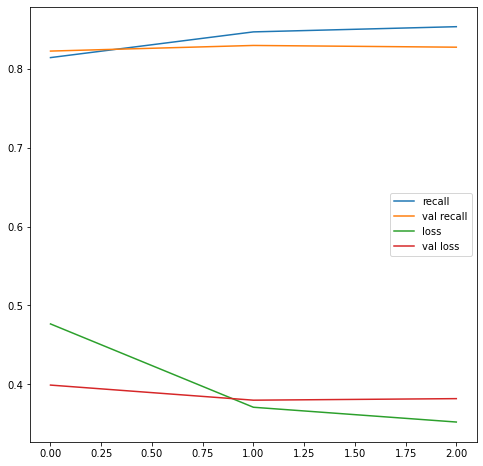

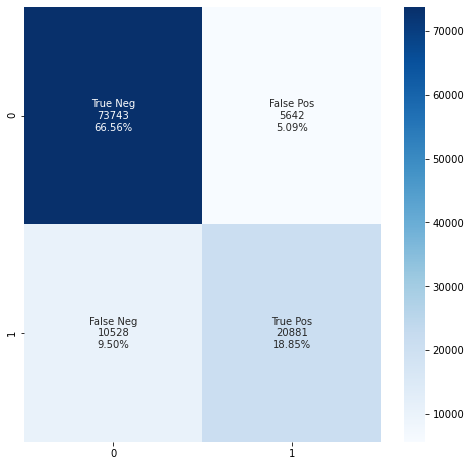

In [9]:
model.load_weights("data/CNN_unbalanced_weights.h5")
save("history_unbalanced")
hist = load("history_unbalanced")
show_results(_model=model, _hist=hist, metric="recall")

## Model with balanced classes (with data augmentation)

In [11]:
# reset test generator
test_gen.reset()

In [12]:
hist = model.fit(x=training_gen_augmented, validation_data=validation_gen_augmented, callbacks=callback("CNN_balanced"), epochs=epochs, batch_size=batch_size, steps_per_epoch=totalTrain_augmented // batch_size, validation_steps=totalVal_augmented // batch_size).history

Epoch 1/50
7085/7085 [==============================] - 323s 46ms/step - loss: 0.2915 - accuracy: 0.8884 - recall: 0.8884 - val_loss: 0.2357 - val_accuracy: 0.9035 - val_recall: 0.9035
Epoch 2/50
7085/7085 [==============================] - 338s 48ms/step - loss: 0.2549 - accuracy: 0.8965 - recall: 0.8964 - val_loss: 0.2263 - val_accuracy: 0.9069 - val_recall: 0.9069
Epoch 3/50
7085/7085 [==============================] - 344s 49ms/step - loss: 0.2444 - accuracy: 0.9003 - recall: 0.9002 - val_loss: 0.2406 - val_accuracy: 0.8992 - val_recall: 0.8992
Epoch 4/50
7085/7085 [==============================] - 352s 50ms/step - loss: 0.2389 - accuracy: 0.9019 - recall: 0.9018 - val_loss: 0.2142 - val_accuracy: 0.9098 - val_recall: 0.9098
Epoch 5/50
7085/7085 [==============================] - 333s 47ms/step - loss: 0.2327 - accuracy: 0.9044 - recall: 0.9044 - val_loss: 0.2199 - val_accuracy: 0.9100 - val_recall: 0.9100


              precision    recall  f1-score   support

           0       0.92      0.84      0.88     79385
           1       0.67      0.82      0.74     31409

    accuracy                           0.83    110794
   macro avg       0.79      0.83      0.81    110794
weighted avg       0.85      0.83      0.84    110794



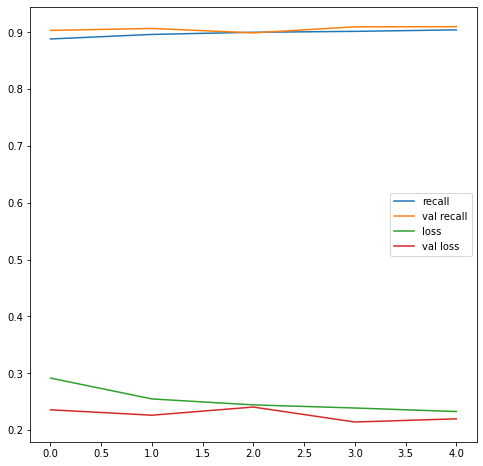

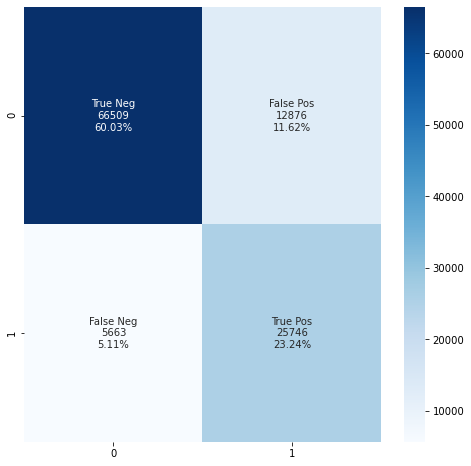

In [13]:
model.load_weights("data/CNN_balanced_weights.h5")
save("history_balanced")
hist = load("history_balanced")
show_results(_model=model, _hist=hist, metric="recall")

## CNN using a pre trained model to extract features + data augmentation

In [14]:
batch_size = 64

In [21]:
# news generators with appropriate params (preprocess function, target_size)
img_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=.15)
training_gen_augmented = img_datagen.flow_from_directory(symblink_path, target_size=(71,71), subset="training", batch_size=batch_size, follow_links=True, shuffle=True)
validation_gen_augmented = img_datagen.flow_from_directory(symblink_path, target_size=(71,71), subset="validation", batch_size=batch_size, follow_links=True, shuffle=False)
test_gen = img_datagen.flow_from_directory(test_path, target_size=(71,71), batch_size=1, shuffle=False)

Found 226722 images belonging to 2 classes.
Found 40008 images belonging to 2 classes.
Found 110794 images belonging to 2 classes.


In [24]:
base_model = Xception(include_top=False, input_shape=(71, 71, 3))
base_model.trainable = False

flatten_layer = Flatten()
dense_layer_1 = Dense(64, activation='relu')
dense_layer_2 = Dense(32, activation='relu')
prediction_layer = Dense(2, activation='softmax')
dropout_layer = Dropout(0.5)

model = Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dropout_layer,
    dense_layer_2,
    prediction_layer
])

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy", recall])

In [25]:
hist = model.fit(x=training_gen_augmented, validation_data=validation_gen_augmented, callbacks=callback("CNN_balanced_transfert_learning"), epochs=epochs, batch_size=batch_size, steps_per_epoch=totalTrain_augmented // batch_size, validation_steps=totalVal_augmented // batch_size).history

Epoch 1/50
3542/3542 [==============================] - 2044s 576ms/step - loss: 0.3297 - accuracy: 0.8588 - recall: 0.8588 - val_loss: 0.2170 - val_accuracy: 0.9040 - val_recall: 0.9040
Epoch 2/50
3542/3542 [==============================] - 1939s 547ms/step - loss: 0.2823 - accuracy: 0.8773 - recall: 0.8773 - val_loss: 0.2155 - val_accuracy: 0.9192 - val_recall: 0.9192
Epoch 3/50
3542/3542 [==============================] - 1818s 513ms/step - loss: 0.2699 - accuracy: 0.8818 - recall: 0.8818 - val_loss: 0.2225 - val_accuracy: 0.8945 - val_recall: 0.8945
Epoch 4/50
3542/3542 [==============================] - 1903s 537ms/step - loss: 0.2615 - accuracy: 0.8847 - recall: 0.8847 - val_loss: 0.2097 - val_accuracy: 0.9215 - val_recall: 0.9215
Epoch 5/50
3542/3542 [==============================] - 1799s 508ms/step - loss: 0.2550 - accuracy: 0.8881 - recall: 0.8881 - val_loss: 0.2145 - val_accuracy: 0.9273 - val_recall: 0.9273


              precision    recall  f1-score   support

           0       0.89      0.89      0.89     79385
           1       0.73      0.71      0.72     31409

    accuracy                           0.84    110794
   macro avg       0.81      0.80      0.80    110794
weighted avg       0.84      0.84      0.84    110794



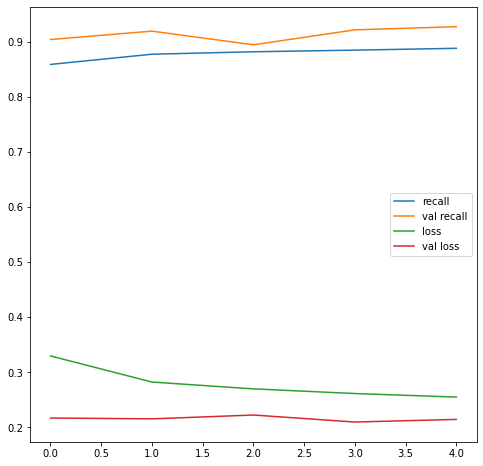

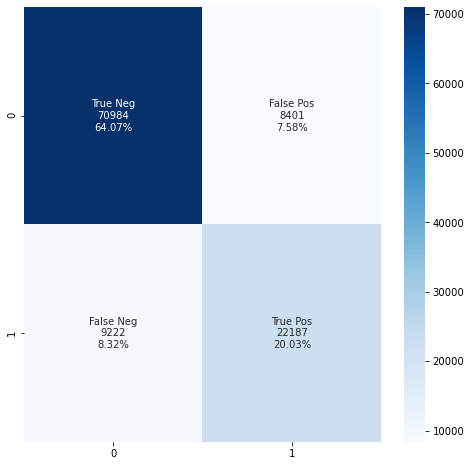

In [26]:
model.load_weights("data/CNN_balanced_transfert_learning_weights.h5")
save("history_balanced_transfert_learning")
hist = load("history_balanced_transfert_learning")
show_results(_model=model, _hist=hist, metric="recall")